# Introduction

The goal of *leakage assessment* is to evaluate the amount of **information leaking** through side channels when a cryptographic algorithm is executed on a hardware target.
If it happens that this leakage is significant, the measures on the side channel and its related statistical processing of acquired traces will allow to recover the intermediate secret values manipulated by the crypto algorithm, and thus break its security.

In our case, we work under the following assumptions:

- cryptographic algorithm: AES128 (*Advanced Encryption Standard* with a key of 128 bits)
- side channel: power consumption
- hardware target : ARM core embedded in a STM32 micro-controller

## Jupyter notebooks (reminder)

Notebooks consist in cells, that contain either:
  - text formatted as [Markdown](https://commonmark.org/help/tutorial/index.html),
  - Python code

Keyboard shortcuts are:
  - `Ctrl+Enter` : execute current cell
  - `Shift+Enter` : execute current cell and go to next one,
  - `a` : add a new cell **before** current cell,
  - `b` : add a new cell **after** current cell,,
  - `y` : convert current cell to Python code,
  - `m` : convert current cell to text cell,
  - `d d` : suppress current cell.

# Set-up

We start by defining useful environment variables
**Check that ChipWhisperer installation path is ok**

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
#CW_PATH = '../chipwhisperer/'
CW_PATH = '/home/vagrant/work/projects/chipwhisperer/'
SS_VER = 'SS_VER_1_1'

We compile the implementation of the AES encryption algorithm suitable for our target (CWLITEARM)

In [2]:
setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

Serial baud rate = 38400
INFO: Found ChipWhisperer😍


## Useful Functions

Let us define a function that will allow us to reset the board

In [3]:
def reset(): 
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    target.flush()

## Firmware board / programming



We program the board by uploading in the Flash memory the file `.hex`. 

In [4]:
import chipwhisperer as cw

fw_path = "./simpleserial-aes-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)
reset()

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6131 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6131 bytes
Serial baud rate = 38400


## Defining communication functions with AES

The firmware consists in a simple AES-128 ciphering. There are 3 commands in the firmware:
1. `k` command + 16 bytes => set the key to this specific value 16 bytes. 
2. `p` command + 16 bytes => cipher the 16-byte message/plaintext with the key defined above.
3. `g` command + 16 bytes => cipher the 16-byte message/plaintext with an **uknown key**. This is the key you should retrieve at the end of the DPA lab. 

In [5]:
from time import sleep
import numpy as np

def send_key(key):
    assert type(key) is np.ndarray, "Key must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in key]), "Key must be a vector of bytes"
    assert np.shape(key) == (16,), "key length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in key]), "The value of each key byte must be between 0 and 255"
    
    target.simpleserial_write('k', bytearray(key))
    sleep(0.01)


def cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('p', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre


def secret_cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('g', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre

If we consider test vectors given in [FIPS standard](https://nvlpubs.nist.gov/nistpubs/FIPS/NIST.FIPS.197.pdf), we can write an assertion to check the correct functioning of the given implementation

In [6]:
plaintext = np.array([0x32, 0x43, 0xF6, 0xA8, 0x88, 0x5A, 0x30, 0x8D, 0x31, 0x31, 0x98, 0xA2, 0xE0, 0x37, 0x07, 0x34],
                dtype=np.uint8)
key = np.array([0x2B, 0x7E, 0x15, 0x16, 0x28, 0xAE, 0xD2, 0xA6, 0xAB, 0xF7, 0x15, 0x88, 0x09, 0xCF, 0x4F, 0x3C],
                dtype=np.uint8)

send_key(key)
ciphertext = cipher(plaintext)
print(ciphertext)

assert ciphertext["full_response"].strip() == 'r3925841D02DC09FBDC118597196A0B32'

## TODO:
## check that when using `secret_cipher` the key is not the same as defined above.
ciphertext1 = secret_cipher(plaintext)
print(ciphertext1)

{'valid': True, 'payload': CWbytearray(b'39 25 84 1d 02 dc 09 fb dc 11 85 97 19 6a 0b 32'), 'full_response': 'r3925841D02DC09FBDC118597196A0B32\n', 'rv': 0}
{'valid': True, 'payload': CWbytearray(b'fc d2 50 4d 24 84 20 63 05 9f b6 fb c8 29 88 30'), 'full_response': 'rFCD2504D24842063059FB6FBC8298830\n', 'rv': 0}


## Measuring the consumption

We are going to measure the power consumption of the microcontroller during the execution of the encryption algorithm.
Let us define the number of samples:
- if this number is too **low**, the power trace may not include the entirety of the target execution,
- if this number is too **high**, the power trace may include useless samples, obtained after the target algorithm has already ended.

Then, we define the amplifier gain:
- if this value is too **low**, the power trace will be strongly discretized and we will lose important information,
- if this value is too **high**, the Analog-Digital converted will be saturated and some samples may be non exploitable.

It is **UP TO YOU** to define good values for the sample number (variable `NB_SAMPLES`) and gain (variable `GAIN`) to acquire the entire AES execution with a reasonable precision.

In [7]:
# TODO
NB_SAMPLES = 24000
GAIN = 2

scope.adc.samples = NB_SAMPLES
scope.gain.db = GAIN

#
scope.adc.decimate = 1
scope.adc.offset = 0
scope.clock.adc_src = "clkgen_x1"

Create now a random key and plaintext pair, encrypt the text with the key, and save the power consumption trace of the encryption process. We will then plot this trace.

Use the function `np.random.randint` to generate random vectors.

Following functions can be used for plotting:

- `plt.plot()` to draw a curve,
- `plt.xlim(start, edn)` to define x-axis' boundaries (likely for y axis),
- `plt.xabel("X title")`, to define a label for the x-axis (likely for y axis),
- `plt.title("Figure title")`, to define a label for the figure
- `plt.show()` to display the figure.


Play with NB_SAMPLES an GAIN to see properly the 10 AES rounds in the plot.

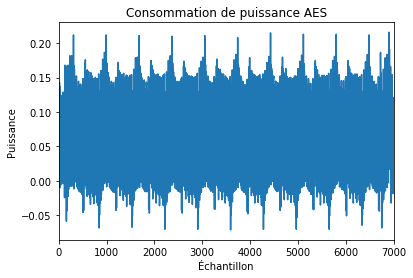

In [8]:
import matplotlib.pyplot as plt
#TO TEST
NB_SAMPLES = 7000
GAIN = 25
scope.adc.samples = NB_SAMPLES
scope.gain.db = GAIN

key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  # TODO
plain = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  # TODO
# TODO
send_key(key)
scope.arm()
ciphertext = cipher(plain)
scope.capture()
trace = scope.get_last_trace()
plt.plot(trace)  
plt.xlabel("Échantillon")  
plt.ylabel("Puissance") 
plt.title("Consommation de puissance AES")
plt.xlim(0, NB_SAMPLES)  
plt.show()  


# Leakage assessment

## Mean of traces

From a pool of $2n$ traces $T_i(t)$, acquired with different plaintexts & ciphertexts, we can define 2 different populations, $P_0, P_1$, with a given relevant criteria to separate the 2 sets. If the 2 sets are statistically different, the means of the traces will be different. 


$<P_0> = \sum_{i=1}^n T_i$ if $i = 0 $ 

$<P_1> = \sum_{i=1}^n T_i$ if $i = 1 $

Thus we can compare the 2 traces and see whether they are different or not. This is the first -- and simplest -- statistical test that we could try. 

## Learning Example (*random VS random*)

### Acquisitions

We start by capturing two sets of traces, each made of $n$ traces, both with **random key and plain text**.

In order to avoid any **biasing**, it is advisable to interleave the trace collection for each set. For this reason, we define a table of $2n$ elements, where the first $n$ are set to 0 and the last $n$ to 1. After randomly shuffling this table, it is the value stored in each row that will state if the acquisition will be destined to the first or the second set.

In [9]:
from tqdm import trange  # For a progress bar

# TODO
NB_TRACES_PAR_ENSEMBLE = 100
random_set_1 = np.zeros((NB_TRACES_PAR_ENSEMBLE+1, NB_SAMPLES))
random_set_2 = np.zeros((NB_TRACES_PAR_ENSEMBLE+1, NB_SAMPLES))

choices = np.array(NB_TRACES_PAR_ENSEMBLE * [0] + NB_TRACES_PAR_ENSEMBLE * [1])

np.random.shuffle(choices)


# TODO    
i = j = 0
for elem in choices:
    key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  # TODO
    plain = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  # TODO
    send_key(key)
    scope.arm()
    ciphertext = cipher(plain)
    scope.capture()
    trace = scope.get_last_trace()
    if elem:
        random_set_1[i] = trace
        i+=1
    else:
        random_set_2[j] = trace
        j+=1


### Mean of traces
The simplest statistical test is to compute the mean of traces for each set. Plot the 2 mean traces and see if you can see differences.

`np.array.mean(axis=0)` will average the `NB_TRACES_PAR_ENSEMBLE` for every time position. 

<IPython.core.display.Javascript object>


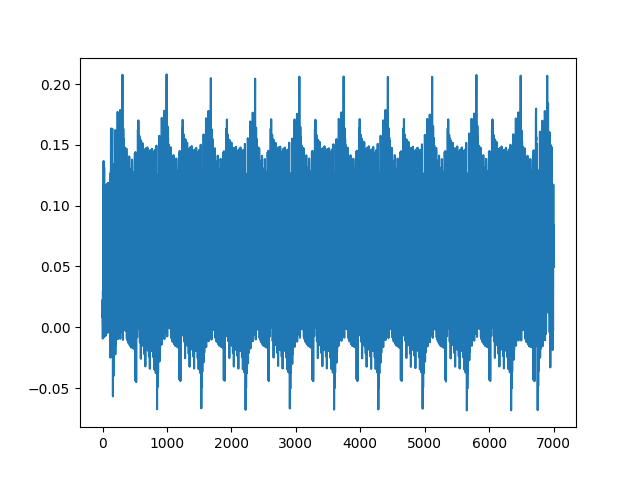

<IPython.core.display.Javascript object>


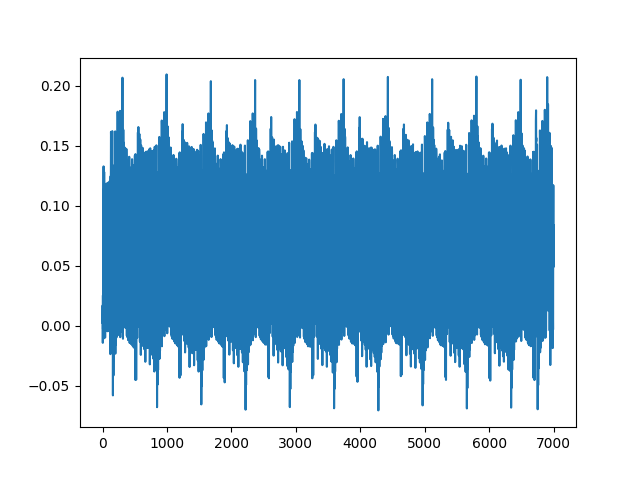

<IPython.core.display.Javascript object>


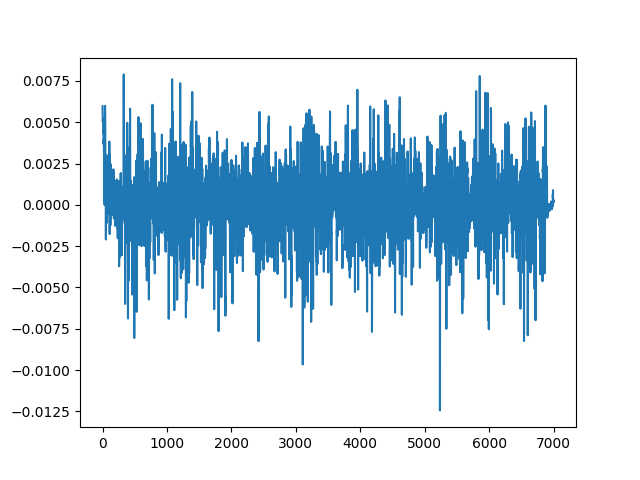

In [25]:
%matplotlib notebook

random_set_1_mean = random_set_1.mean(axis=0)

plt.figure('Random set 1')
plt.plot(random_set_1_mean)
plt.show()

random_set_2_mean = random_set_2.mean(axis=0)

plt.figure('Random set 2')
plt.plot(random_set_2_mean)
plt.show()

plt.figure('Difference of averages')
plt.plot(random_set_1_mean - random_set_2_mean)
plt.show()  

_What would you say of the differences between the 2 curves ?_

The difference between the two waveform is negligible compared to the order of magnitude of the measurment. Specifically, the difference is 2 order of magnitude smaller compared to the plots. This implies that we cannot distinguish the two sets and that it is mostly noise.

## Non specific Characterisation (*fixed VS random*)

Let's try to determine if 2 sets of curves are different.

Our goal is to perform now a **non-specific** caracterisation.
This means that we do **not** aim at verifying if a **specific intermediate value** leaks information, but rather quickly estimate the amount of leakage.

To do this, we do a $t$-test on two sets of traces:
- a first set with **fixed** key and plain text
- a second set with **random** key and plain text

The benefits of a non-specific characterization are the a single $t$-test is performed, which gives us information about all the leakages observed during the execution of the implemented algorithm. 
On the other hand, in case of test showing leakages, it gives very little information about the specific intermediate values that are leaking. Likewise, this test does not give any information concerning the actual exploitability of these leakages by a potential attacker.

### Acquisitions

In [11]:
from tqdm import trange  # Barre de progression

NB_TRACES_PAR_ENSEMBLE = 100
NB_ECHANTILLONS = 7000

fixed_set = np.zeros((NB_TRACES_PAR_ENSEMBLE, NB_ECHANTILLONS))
random_set = np.zeros((NB_TRACES_PAR_ENSEMBLE, NB_ECHANTILLONS))

choices = np.array(NB_TRACES_PAR_ENSEMBLE * [0] + NB_TRACES_PAR_ENSEMBLE * [1])
np.random.shuffle(choices)

i_fixed_set = 0
i_random_set = 0
cle_fixe = np.random.randint(0, 256, 16, np.uint8)
clair_fixe = np.random.randint(0, 256, 16, np.uint8)

for trace in trange(2 * NB_TRACES_PAR_ENSEMBLE):
    if choices[trace] == 0:
        send_key(cle_fixe)
        scope.arm()
        cipher(clair_fixe)
        scope.capture()
        fixed_set[i_fixed_set, :] = scope.get_last_trace()
        i_fixed_set += 1
    else:
        cle_random = np.random.randint(0, 256, 16, np.uint8)
        clair_random = np.random.randint(0, 256, 16, np.uint8)
        send_key(cle_random)
        scope.arm()
        cipher(clair_random)
        scope.capture()
        random_set[i_random_set, :] = scope.get_last_trace()
        i_random_set += 1

100%|██████████| 200/200 [00:21<00:00,  9.44it/s]


### Mean of traces

Reproduce the mean of traces test and plot it


<IPython.core.display.Javascript object>


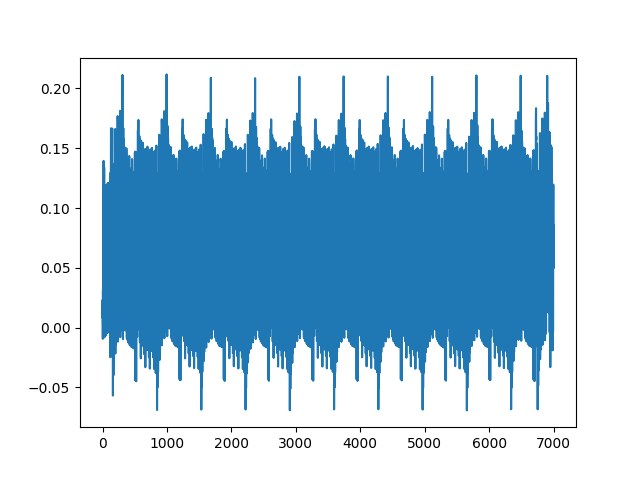

<IPython.core.display.Javascript object>


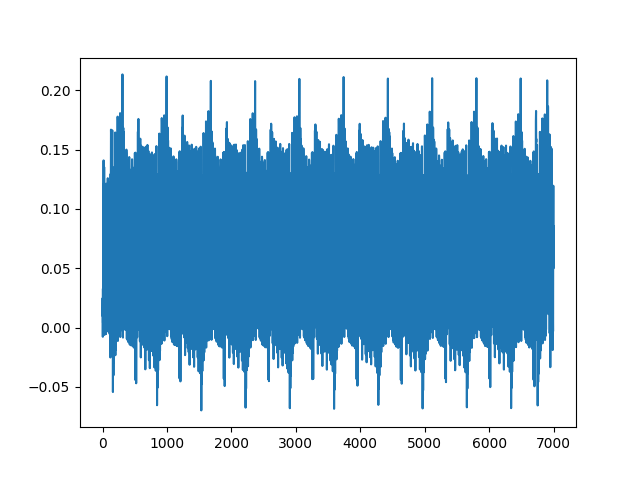

<IPython.core.display.Javascript object>


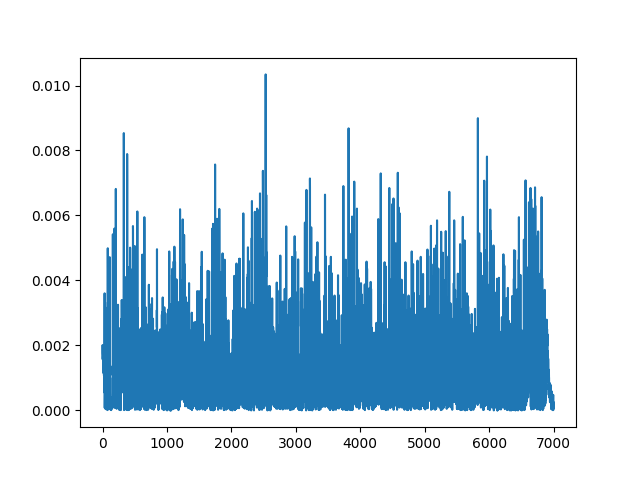

In [12]:
%matplotlib notebook
plt.figure('random_set')
plt.plot(random_set.mean(axis=0))
plt.figure('fixed_set')
plt.plot(fixed_set.mean(axis=0))

plt.figure('difference')
plt.plot(abs(random_set.mean(axis=0)-fixed_set.mean(axis=0)))
plt.show()

_Do you see any differences ?_

The difference is more considerable compare to the previous test. Specifically, the difference is 1 order of magnitude smaller compared to the plots.

It is complicated to determine if these are relevant leakages. It depends on standard deviation of the traces. 
Plot the standard deviaton `np.array.mean(axis=0)` for both curves.

<IPython.core.display.Javascript object>


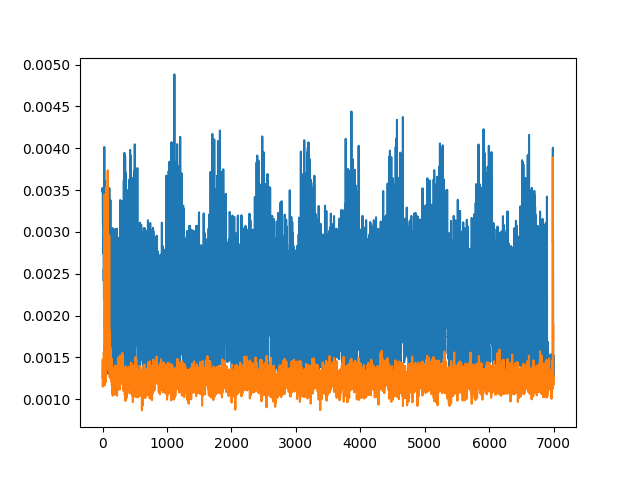

In [13]:
## TODO
plt.figure('random vs fixed')
plt.plot(random_set.std(axis=0))
plt.plot(fixed_set.std(axis=0))

plt.show()


_Can you define a relevant criteria to know if there are leakages ?_

The use of standard deviation is useful in this specific case since one set is fixed (low std) and one set is random (high std). For two random set the usage of standard deviation is not useful.

It seems clear that we need a specific test to determine whether the crypto leaks or not. This is the purpose of next sections, dedicated to $t$-tests. 

## Test of equality of means: Student $t$-test 

When we compute a $t$-test, we test the following null hypothesis $H_0$:
> $H_0$ : the expected value of two population is identical

In our case, the two populations are power consumption traces, collected under *different* conditions.
The test is going to reveal if the two sets are statistically distinguishable.

We compute the Student $t$-test under the following assumptions:
- test on **two samples**, i.e. we test two sets (unlike the test on **one sample** that tests one sets with respect to an expected average value),
- test of samples **of the same size**, i.e. the two sets have (more or less) the **same cardinality**,
- test at **equal variance**, i.e. the two sets have the **same variance**.

All these assumptions may be removed if using the Welch's $t$ test, with results ($t$ values, $p$ values) that are slightly different. 

### Computation of the $t$-statistics

We compute the $t$-test statistics over two sets of $n$ elements with the [following equation](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_sample_sizes_and_variance) :  
$t = \frac{\bar{X_1} - \bar{X_2}}{s_p\sqrt{\frac{2}{n}}}$ where $\bar{X_i}$ is the [experimental average](https://en.wikipedia.org/wiki/Estimator) of the set $X_i$  
and with $s_p = \sqrt{\frac{s_{X_1}^2 + s_{X_2}^2}{2}}$ where $s_{X_i}$ is the [unbiased variance estimator](https://fr.wikipedia.org/wiki/Estimateur_(statistique)#Estimateur_de_la_variance_de_Y) of the set $X_i$.

In this case, the test has $2n-2 \simeq 2n$ degrees of freedom.

### Interpretation of the value of $t$

The $t$-test follows a law by Student with $2n-2$ degrees of freedom. For a Student law of a given degree of freedom, we can find the value of $t$ corresponding to the risk of accepting the null hypothesis $H_0$ even if this is not true. Such values of $t$ are usually tabulated in precomputed [tables](https://en.wikipedia.org/wiki/Student%27s_t-distribution#Table_of_selected_values) for ease of use. We are in the case of a *two-sided* analysis, as we do not know in advance which set is going to have the larger mean.

For example, if we aim at a confidence level of 99.9% of wrongly refusing the null hypothesis (which means, in our case, concluding that there is no information leakage when there is actually some), with 100 degrees of freedom, then $|t| < 3.39$.

In general, when we perform a leakage assessment on a cryptographic algorithm, the confidence level taken into consideration is even higher, the order of 99.999%. In this case, if $|t| < 4.5$, we can conclude positively on the absence of exploitable leakage.

### Practice

The package `scipy.stats` includes the function `ttest_ind` that allows performing a $t$-test. 

In [14]:
from scipy.stats import ttest_ind
help(ttest_ind)

Help on function ttest_ind in module scipy.stats.stats:

ttest_ind(a, b, axis=0, equal_var=True, nan_policy='propagate')
    Calculate the T-test for the means of *two independent* samples of scores.
    
    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.
    
    Parameters
    ----------
    a, b : array_like
        The arrays must have the same shape, except in the dimension
        corresponding to `axis` (the first, by default).
    axis : int or None, optional
        Axis along which to compute test. If None, compute over the whole
        arrays, `a`, and `b`.
    equal_var : bool, optional
        If True (default), perform a standard independent 2 sample test
        that assumes equal population variances [1]_.
        If False, perform Welch's t-test, which does not assume equal
        population variance [2]_.
    
   

This function can also perform a Welch's $t$-test when `equal_var` is set to `False`. This test can be used for more general tests of 2 sets without any assumptions on sample size nor equal variance. You can try both functions and see the differences. 

### $t$-test computation

_Perform a $t$-test to compare the random and the fix set to check if the mean are statistially different_

<IPython.core.display.Javascript object>


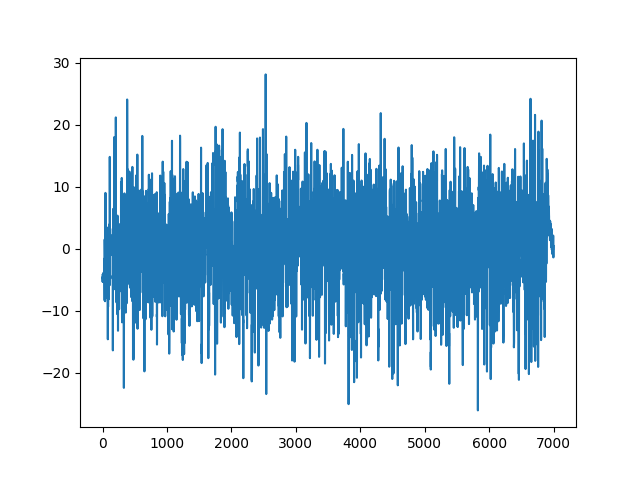

In [15]:
# TODO
result = ttest_ind(random_set,fixed_set, equal_var = False)

plt.figure()
plt.plot(result.statistic)
plt.show()


**NOTA BENE**

During an actual assessment, it is good practice to do the test several times with a fixed value different for each test; this would allow to get rid as much as possible of any biasing related to the specific fixed values that were chosen.

### $t$-test computation on random sets

As the two sets of traces have been built under **the same conditions**, there is **no** reason that they should be **statistically different**.

We check hence that these two sets are actually **statistically equivalent** by plotting the values of the $t$-test for each sample, and checking the validity of the $t$-test leakages assessment. 

<IPython.core.display.Javascript object>


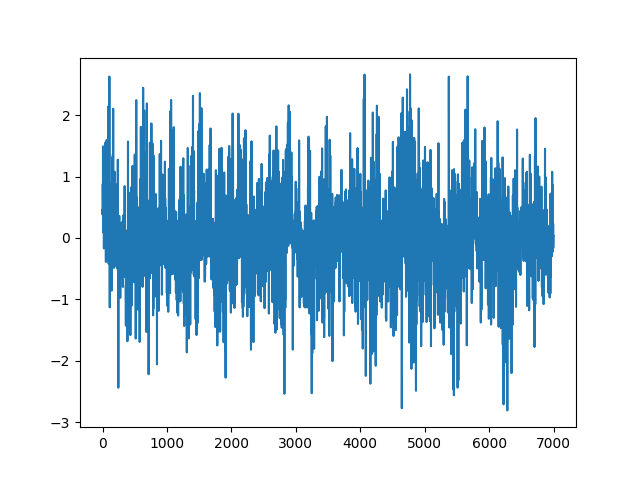

In [16]:
# TODO
result = ttest_ind(random_set_1,random_set_2, equal_var = False)

plt.figure()
plt.plot(result.statistic)
plt.show()

### Non-specific fixed-key characterization

We can put ourselves in a stricter evaluation context if we characterize the leakage with a fixed key value. This would actually represent the scenario where the key would be unknown and hardcoded in the circuit itself.

In order to complete this step, we compute a $t$-test on two sets of traces, both collected using the **same fixed key**:
- a first set made by a **fixed** plain text
- another set made with a **random** plain text

Complete this step and prove whether leakages are detectable in this context.

<IPython.core.display.Javascript object>


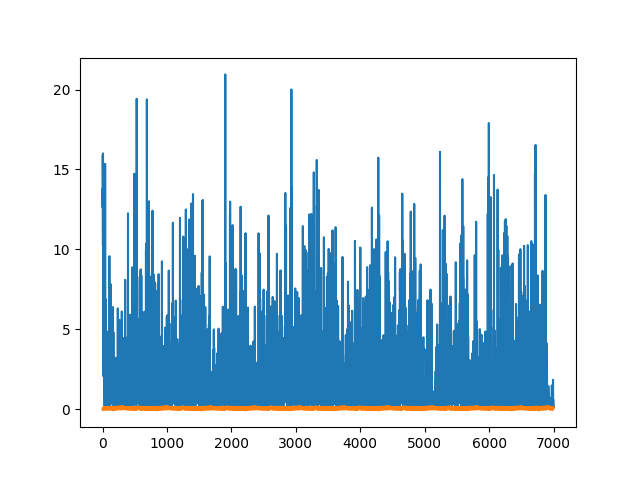

In [17]:
# TODO

NB_TRACES_PAR_ENSEMBLE = 100
random_set_1 = np.zeros((NB_TRACES_PAR_ENSEMBLE+1, NB_SAMPLES))
random_set_2 = np.zeros((NB_TRACES_PAR_ENSEMBLE+1, NB_SAMPLES))

choices = np.array(NB_TRACES_PAR_ENSEMBLE * [0] + NB_TRACES_PAR_ENSEMBLE * [1])

np.random.shuffle(choices)

key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  

i = j = 0
for elem in choices:
    if elem:
        plain = np.random.randint(low=0, high=256, size=16, dtype=np.uint8) 
    else:
        plain = np.array([0x32, 0x43, 0xF6, 0xA8, 0x88, 0x5A, 0x30, 0x8D, 0x31, 0x31, 0x98, 0xA2, 0xE0, 0x37, 0x07, 0x34],
                dtype=np.uint8)
    send_key(key)
    scope.arm()
    ciphertext = cipher(plain)
    scope.capture()
    trace = scope.get_last_trace()
    if elem:
        random_set_1[i] = trace
        i+=1
    else:
        random_set_2[j] = trace
        j+=1
    
result = ttest_ind(random_set_1,random_set_2, equal_var = False)

plt.figure()
plt.plot(abs(result.statistic))
plt.show()

## Specific Characterization

After assessing that the AES implementation we are currently using has some leakages during its execution (which was expected), we may try to identify the leakages associated to some specific intermediate values. When attacking curves (e.g. DPA), these specific intermediate values are called sensitive variables $\nu $ or target variables. They will be later used in the DPA lab. 

The first AES rounds is depicted below and shows the 3 possible leakages we will try in this specific characterization.

<img src="./images/AES_first1.png" alt="First AES rounds" width="450"/>

As we are going to use the intermediate values in order to identify the leakage, we need to **store in the memory** the random values used for the keys and plaintexts.

### Acquisitions

In [18]:
# TODO
NB_TRACES = 1000
plain_array = np.zeros((NB_TRACES, 16), dtype=np.uint8)
key_array = np.zeros((NB_TRACES, 16), dtype=np.uint8)
traces = np.zeros((NB_TRACES,NB_SAMPLES))

send_key(key)
scope.arm()
cipher(plain)
scope.capture()
trace = scope.get_last_trace()
plt.plot(trace)


for trace in trange(NB_TRACES):
    key_array[trace, :] = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)  
    plain_array[trace, :] = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)
    
    send_key(key_array[trace])
    
    scope.arm()
    cipher(plain_array[trace,:])
    
    scope.capture()
    traces[trace] = scope.get_last_trace()

100%|██████████| 1000/1000 [01:06<00:00, 15.05it/s]


### $t$-test for key leakage assessment

We start by measuring key leakages, i.e. we check whether we could directly attack the key.  
To do so, we separate all traces in two partitions:
- Traces where the Least Significant Bit (LSB) of the first key byte is 0,
- Traces where the Least Significant Bit of the first key byte is 1

If these two partitions are statistically distinguishable, this means that the power consumption of the micro-controller depends on the LSB of the first key byte.
A statistical analysis of this power consumption will thus reveal the value of this key byte.

In order to find the samples where the $t$ statistics is larger than the threshold value (4.5), use the function `np.where`:
`np.where(np.abs(t_stats) > 4.5)`

In [19]:
# Help to create the two sets 
test = np.arange(10)
test_2 = np.arange(0, 20, 2)
print(test % 2 == 0)
# If an element of vector 'test' is equal to 0 modulo 2,
# then choose the element with the same index in vector 'test_2'
print(test_2[test % 2 == 0])

[ True False  True False  True False  True False  True False]
[ 0  4  8 12 16]


<IPython.core.display.Javascript object>


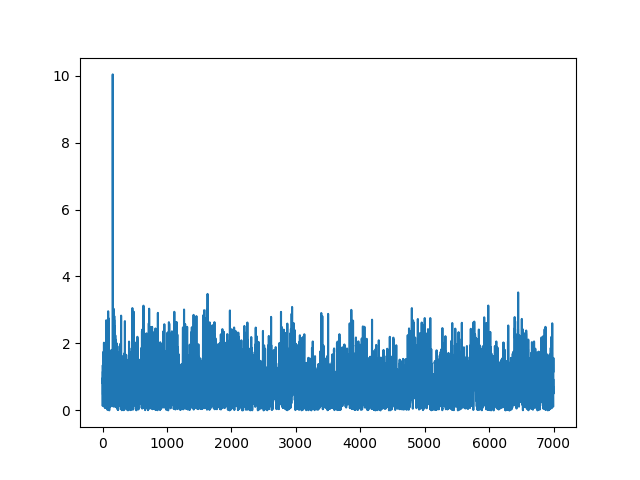

(array([158, 159]),)


In [20]:
# TODO

lsb_zero = []
lsb_one = []

def single_byte(n_byte):
    
    i = 0
    for elem in key_array:
        if elem[n_byte] % 2 == 0:
            lsb_zero.append(traces[i])
        else:
            lsb_one.append(traces[i])
        i+=1

    return ttest_ind(lsb_zero,lsb_one, equal_var = False)

result = single_byte(0)

plt.figure()
plt.plot(abs(result.statistic))

plt.show()
print(np.where(np.abs(result.statistic) > 4.5))

We can repeat this partitioning in two sets for the LSBs of each byte of the key (out of 16), and then overlap all the curves that we obtained.

You should be able to clearly identify the **consecutive processing** of the 16 bytes of the key.

<IPython.core.display.Javascript object>


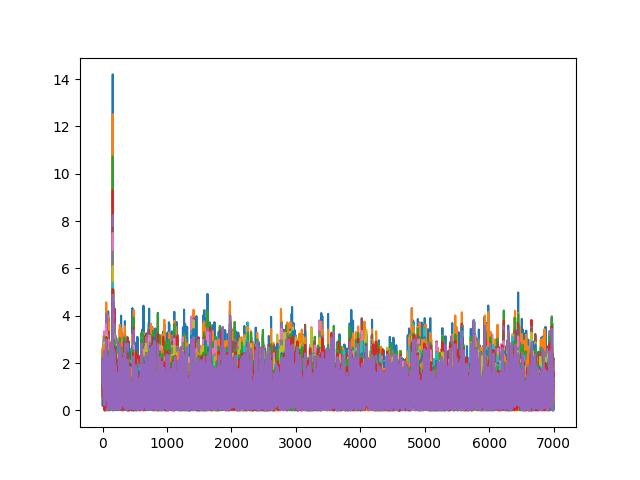

(array([ 158,  159,  160, 1630, 1631, 6451]),)
(array([  57,  158,  159,  160,  166, 1977]),)
(array([158, 159, 160, 166]),)
(array([158, 159, 160, 166]),)
(array([158, 159, 166]),)
(array([158, 159]),)
(array([158, 159]),)
(array([158]),)
(array([158]),)
(array([158]),)
(array([158]),)
(array([158]),)
(array([158]),)
(array([158]),)
(array([158]),)


In [21]:
# TODO

results = []
for i in range(0,15):
    results.append(single_byte(i))
    
plt.figure()
for i in range(0,15):
    plt.plot(abs(results[i].statistic))
    print(np.where(np.abs(results[i].statistic) > 4.5))
plt.show()


### $t$-test computation for leakages in the first `AddRoundKey`

If the algorithm is known, it is possible to test the leakage at specific rounds / steps along the algorithm. A reminder of the first AES rounds is reproduced here.  


We can as well characterize the leakages in the output of the `AddRoundKey` function, which computes the eXclusive OR operation between the bytes of the plain text and the bytes of the round key (the secret key for the initial whitening phase).

Use the function `np.bitwise_xor()` to compute the binary XOR operation between two vectors.

<IPython.core.display.Javascript object>


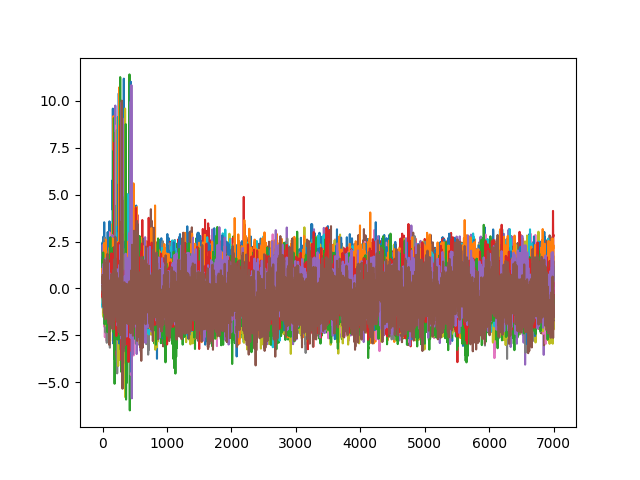

0 (array([157, 159, 160, 161, 327, 328, 329, 330, 331]),)
1 (array([165, 168, 169]),)
2 (array([173, 176, 177, 187, 416, 417, 418, 419, 422, 423, 424, 430]),)
3 (array([ 184,  185, 2191, 2192]),)
4 (array([195, 198, 199, 338, 340, 341]),)
5 (array([206, 207]),)
6 (array([214, 215, 428, 429, 440]),)
7 (array([222, 223, 227]),)
8 (array([236, 237, 348, 349, 350, 351, 354, 355]),)
9 (array([244, 245, 392]),)
10 (array([249, 252, 253, 436, 437, 438, 439]),)
11 (array([257, 258, 259, 260, 261, 480]),)
12 (array([ 274,  275,  305,  358,  360,  361,  365,  366,  376, 1131]),)
13 (array([282, 283]),)
14 (array([287, 290, 291, 305, 446, 448, 449, 454, 455, 456]),)
15 (array([298, 299, 303, 305, 310, 315, 316]),)


In [22]:
xored = plain_array[:,:] ^ key_array[:,:]
#print(xored, len(xored))

plt.figure()
for key_index in range(16):
    traces0 = traces[xored[:,key_index] % 2 == 0]
    traces1 = traces[xored[:,key_index] % 2 == 1]
    t_stats = ttest_ind(traces0, traces1, axis=0).statistic
    
    plt.plot(t_stats)
    print(key_index, np.where(np.abs(t_stats) > 4.5))

# plt.legend()
plt.show()

### $t$-test computation for leakages in the output of first Sbox

And finally we can characterize the leakages at the output of the SBox (SubBytes) operation, which will also be used in the following practical works to mount side channel attacks.

In [23]:
Sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16])

<IPython.core.display.Javascript object>


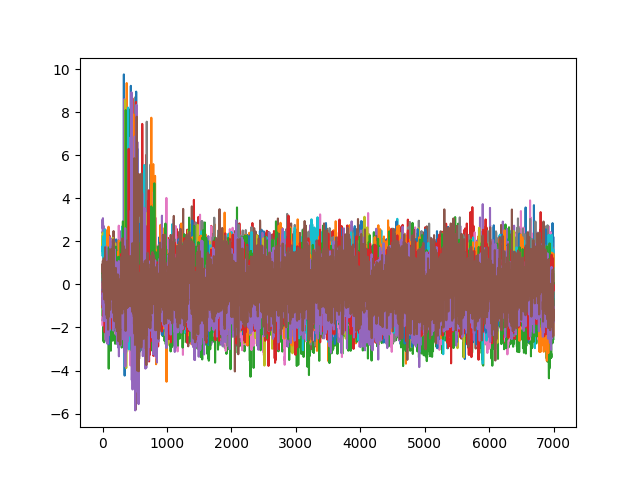

0 (array([330, 331, 332, 543]),)
1 (array([374, 375, 376, 520, 521, 776, 787, 993]),)
2 (array([418, 419, 524, 525]),)
3 (array([462, 463, 540, 616, 617, 675]),)
4 (array([340, 341, 540]),)
5 (array([384, 385, 512, 514, 515, 547, 577]),)
6 (array([428, 429, 528, 529]),)
7 (array([472, 473, 534, 686, 687, 745]),)
8 (array([350, 351]),)
9 (array([394, 395, 516, 517, 647]),)
10 (array([438, 439, 440, 522, 523]),)
11 (array([482, 483, 532, 756, 757, 815]),)
12 (array([360, 361, 804]),)
13 (array([404, 405, 500, 518, 519, 520]),)
14 (array([448, 449, 466, 500, 507, 526, 527, 537, 538, 540, 544, 549, 552,
       553, 554, 560, 561]),)
15 (array([492, 493, 530, 531, 547, 605]),)


In [24]:
# TODO
plt.figure()
for key_index in range(16):
    traces0 = traces[Sbox[xored[:,key_index]] % 2 == 0]
    traces1 = traces[Sbox[xored[:,key_index]] % 2 == 1]
    t_stats = ttest_ind(traces0, traces1, axis=0).statistic
    
    plt.plot(t_stats)
    print(key_index, np.where(np.abs(t_stats) > 4.5))

# plt.legend()
plt.show()

## To go further...

A research paper on this topic, the leakage assessment:

Tobias Schneider, Amir Moradi  
**Leakage Assessment Methodology - A Clear Roadmap for Side-Channel Evaluations**  
*International Workshop on Cryptographic Hardware and Embedded Systems 2015: 495-513*

available at this address: https://eprint.iacr.org/2015/207.pdf